In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target Encoding all Features: Vary midpoint, remove low volume from training
No blending of hierarchy, just target encode all of the NAICS hierarchy features (separately).  Vary the parameter lambda_k, the blending midpoint

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
# Hierarchical encoder on one feature is just regular target encoding
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder 

In [6]:
sg_plot.plot_defaults()

## Import Processed Datasets

In [7]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [8]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [9]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [10]:
train_counts = pd.read_parquet(Path(setup.temp_path).joinpath('A60_DATA_train_counting.parquet')) 

##### Comparison metrics

In [11]:
metrics_base = pd.read_csv(Path(setup.temp_path).joinpath('A61_REPORT_metrics.csv'))

In [12]:
# Standard target encoding
metrics_tenc = pd.read_csv(Path(setup.temp_path).joinpath('A60_REPORT_metrics.csv'))

In [13]:
# Target+Count
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A62_REPORT_metrics.csv'))

In [14]:
# Target-Thresh
metrics_tt = pd.read_csv(Path(setup.temp_path).joinpath('A63_REPORT_metrics.csv'))

## Function to get metrics

In [23]:
def get_metrics(data, lambda_k = setup.selected_lambda_k,
                enc_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']):
    
    data['NAICS_orig'] = data['NAICS']
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:HierarchicalEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[[f]]) for f in enc_features],
                    axis=1, keys=enc_features)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    # Remove low volume codes from train only
    counts_thresh = train_counts[train_counts['count'] > lambda_k][['NAICS']]
    train_df = train_df.merge(counts_thresh.rename(columns={'NAICS':'NAICS_orig'}),
                               on='NAICS_orig')
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [24]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [25]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c)
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [26]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.665406,0.422989,0.308019,0.674901,0.349077,0.730610,1.0,5
1,test,0.661578,0.420338,0.305146,0.675239,0.351207,0.730637,1.0,10
1,test,0.664222,0.422830,0.307447,0.676846,0.351553,0.731247,1.0,20
1,test,0.665960,0.419419,0.306518,0.663988,0.353574,0.731517,1.0,50
1,test,0.674491,0.421685,0.311366,0.653075,0.354024,0.732376,1.0,100
1,test,0.675798,0.421526,0.311889,0.650030,0.352980,0.733111,1.0,200
1,test,0.678196,0.423623,0.314013,0.650791,0.354339,0.734090,1.0,500
1,test,0.658258,0.426282,0.306707,0.698672,0.361670,0.736168,1.0,1000
1,test,0.614447,0.422616,0.290309,0.776499,0.353580,0.731449,1.0,2000


In [27]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.659665,0.451677,0.337777,0.681475,0.386732,0.730533,0.0,5
0,test,0.659344,0.451708,0.337633,0.682204,0.386498,0.730274,0.0,10
0,test,0.660371,0.451870,0.338211,0.680591,0.386959,0.730717,0.0,20
0,test,0.659708,0.451784,0.337845,0.681683,0.386411,0.730719,0.0,50
0,test,0.660040,0.452101,0.338149,0.681891,0.386788,0.730399,0.0,100
0,test,0.659526,0.451538,0.337647,0.681371,0.384966,0.729458,0.0,200
0,test,0.654240,0.448518,0.333757,0.683556,0.377766,0.725298,0.0,500
0,test,0.648494,0.447193,0.330514,0.691203,0.374725,0.722439,0.0,1000
0,test,0.607191,0.441673,0.312077,0.755345,0.359740,0.713553,0.0,2000


In [28]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A64_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A64_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

In [29]:
metrics_sum_dict = {'menc':metrics_tenc,
                    'mhier':metrics_base,
                    'menc_all': metrics_df,
                    'tc': metrics_tc,
                    'tt': metrics_tt}

In [30]:
def make_plot(sum_dict, holdout_val, 
              hline_val = None,
              yfeature = 'average_precision_score', ylabel = 'PR-AUC',
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'c',
                                       yfeature = yfeature,
                                       xlabel='blend midpoint or count threshold',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

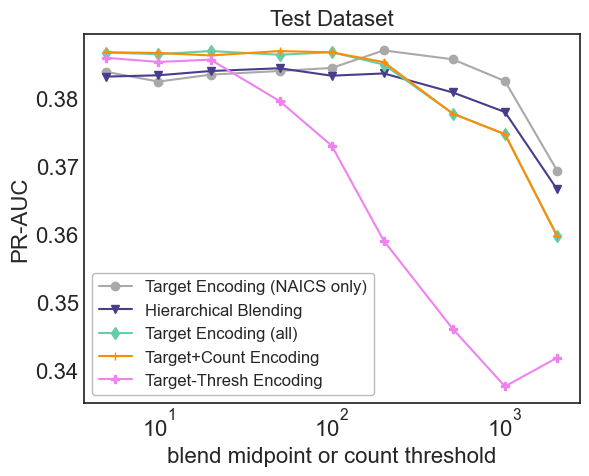

In [31]:
fig = make_plot(metrics_sum_dict, 0, 
                title='Test Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A64_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

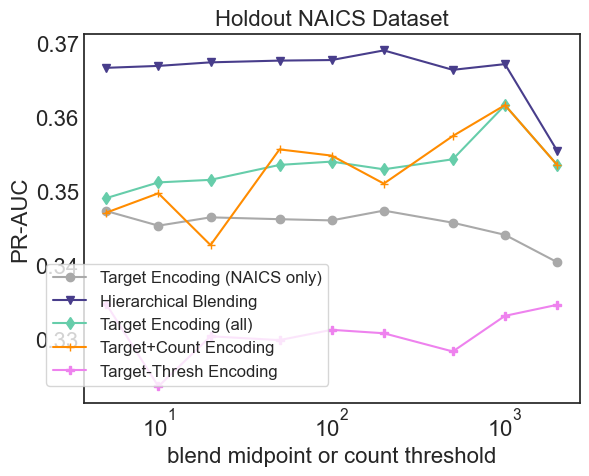

In [32]:
fig = make_plot(metrics_sum_dict, 1, 
                title='Holdout NAICS Dataset')
plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.51, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A64_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

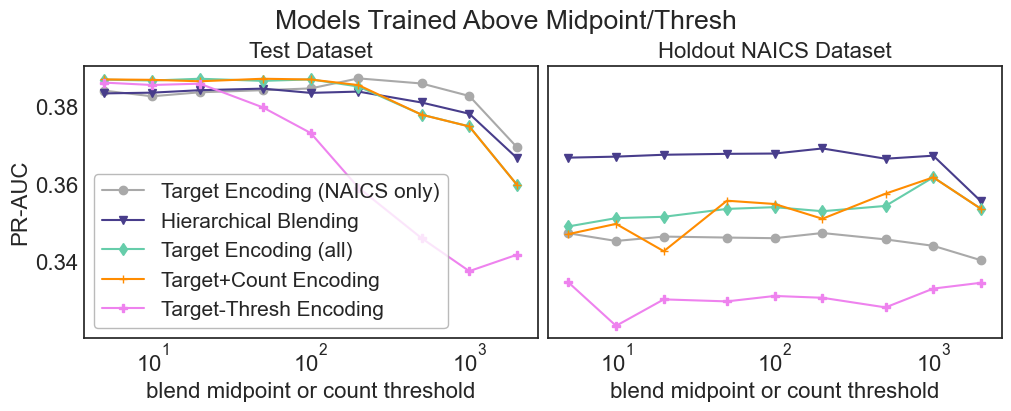

In [34]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, 
                title='Test Dataset',
         ax=ax[0],
         legendsize=15)
make_plot(metrics_sum_dict, 1,
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[1].legend().set_visible(False)
fig.suptitle('Models Trained Above Midpoint/Thresh')
fig.savefig(Path(setup.temp_path).joinpath('A64_PLOT_compare_base_combined.png'),
            bbox_inches='tight')